# AIPI 590 - XAI | Assignment 07

Description: In this assignment we will generate a hypothesis regarding a deep learning model and test said hypothesis utilizing saliency mapping for a given image.

John Coogan

Inspired by an example pitfall for machine learning: that models trained to detect planes vs tanks ended up activating on the sky since that was the prime delimeter between the two classes, we will attempt to assess a size bias for ResNet50.

$ H_0$: ResNet50’s classification accuracy and salience map activations are not significantly affected by the size of the object in the image. Small objects in large images are classified with similar accuracy and focus as larger objects, showing no bias in activation towards object size.

$ H_1$: ResNet50 struggles with classifying small objects in large images, indicating that salience maps will show low activation on the object of interest when it occupies a small portion of the image.

In [ ]:
!pip install numpy==1.25.2 matplotlib==3.7.1 tensorflow==2.14.1

In [2]:
# Basic
import numpy as np
import matplotlib.pyplot as plt

# Model Utils
import tensorflow as tf

# Data Utils
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from keras.utils import get_file
import json

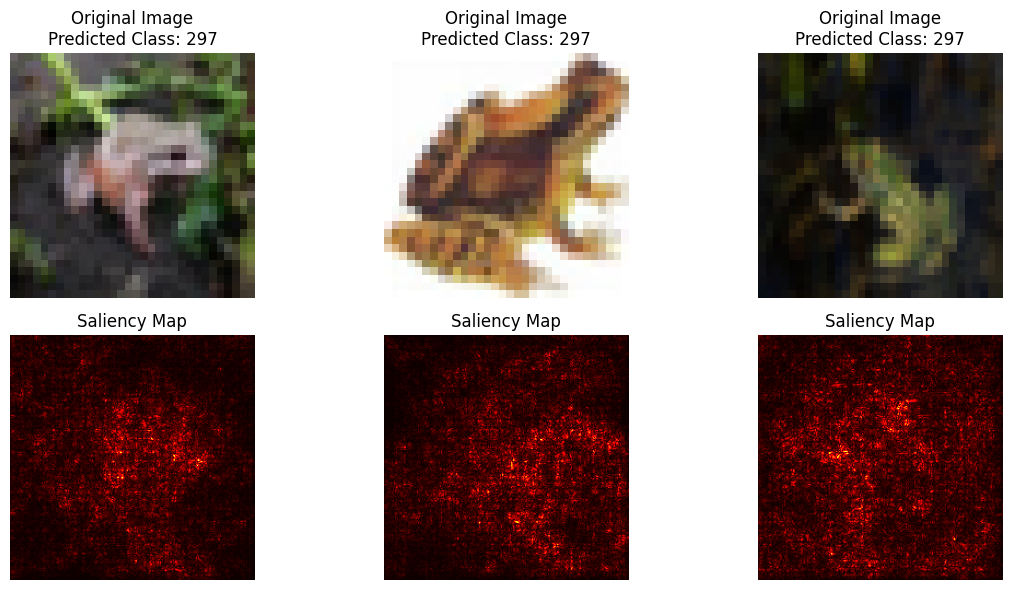

In [64]:


# Function to generate a saliency map for an input image based on a given model
def generate_saliency_map(model, img):
    # Convert the input image to a TensorFlow variable and ensure it's a float tensor
    x = tf.Variable(tf.convert_to_tensor(img, dtype=tf.float32))

    # Add an extra dimension to the image tensor to match the model's input shape
    x = tf.expand_dims(x, axis=0)

    # Preprocess the image according to ResNet50 requirements
    x = tf.keras.applications.resnet50.preprocess_input(x)

    # Create a gradient tape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor to calculate gradients
        tape.watch(x)

        # Forward pass: get model predictions for the input image
        preds = model(x)

        # Find the index of the highest predicted class probability
        top_pred_index = tf.argmax(preds[0]).numpy()  # Convert to numpy immediately

    # Calculate the gradients of the top prediction with respect to the input image
    grads = tape.gradient(preds, x)

    # Compute the saliency map by taking the maximum absolute gradient across color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    # Return the saliency map and the index of the top predicted class as a numpy array
    return saliency.numpy(), top_pred_index

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Choose a class to process, for example, 'cat' (index 3)
class_to_process = 6

# Initialize a list to store images of the specified class

# Get all indices of the images that belong to the specified class
class_indices = np.where(test_labels.flatten() == class_to_process)[0]

# Shuffle the indices
np.random.shuffle(class_indices)

# Select the first three indices from the shuffled list, ensuring there are enough images
selected_indices = class_indices[:3] if len(class_indices) >= 3 else class_indices

# Initialize a list to store the selected images
selected_images = [test_images[i] for i in selected_indices]


# Load the ResNet50 model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Resize selected images to 224x224 for ResNet50
resized_images = [tf.image.resize(img, (224, 224)).numpy() for img in selected_images]

# Generate saliency maps for the resized images
saliency_maps = []
predicted_classes = []
for img in resized_images:
    saliency, top_pred = generate_saliency_map(model, img)
    saliency_maps.append((saliency, top_pred))
    predicted_classes.append(top_pred)  # Store the predicted classes

# Plot the results
plt.figure(figsize=(12, 6))
for i, (saliency, pred_index) in enumerate(saliency_maps):
    plt.subplot(2, 3, i + 1)
    plt.imshow(selected_images[i])
    plt.title(f"Original Image\nPredicted Class: {top_pred}")  # Use the raw prediction index
    plt.axis('off')

    plt.subplot(2, 3, i + 4)
    plt.imshow(saliency, cmap='hot')
    plt.title('Saliency Map')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Results:

We can see from the saliency mapping and these three images of a frog that, as distance awayf from the object increases, the saliency density appears to decrease as well. The image on the far right is most distant and the saliency activation appears to be activating on more of the complete image than should be necessary or is otherwise done for more close up images.

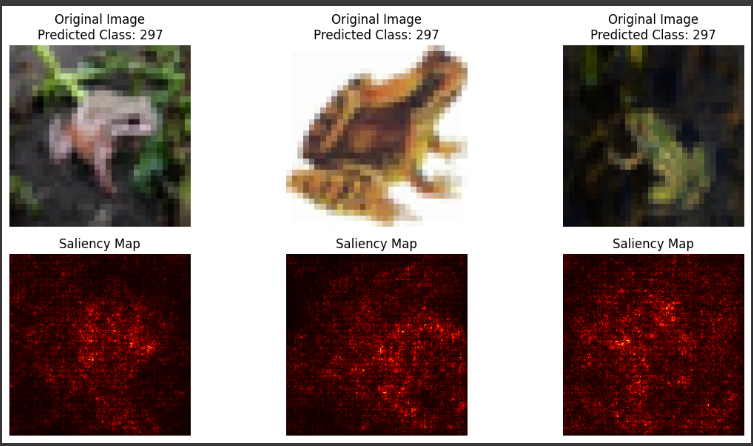